In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
from math import ceil, prod

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

import scripts.dns_specifics as DS
from model import *

#sns.set(style='darkgrid')

np.random.seed(42)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: \"{device}\"')

Device: "cuda:0"


# Data

In [3]:
%%capture --no-display
base_shape = (128, 128)
axis_array = 2 * [np.linspace(0, 2*np.pi, 128+1)[:-1]]
dx = axis_array[0][1]-axis_array[0][0]
dy = axis_array[1][1]-axis_array[1][0]

In [4]:
# # Load data from binary files
# snapshots = []
# for i in range(200):
#     binary = open(f'./turbulence_data/vortJP_0000.{str(i).zfill(3)}', 'rb')
#     binary.seek(0)
#     snap = np.fromfile(binary, dtype='float64', count=128**2).reshape(128, 128)
#     snap = DS.all_syms(snap,
#         base_shape=base_shape,
#         dx=dx,
#         dy=dy,
#         x_shift=2*np.pi*np.random.rand(),
#         m=np.random.randint(326),
#         n=4)
#     snapshots.append(snap)

# # Shift data and add for generalization
# # original_dataset_size = len(snapshots)
# # n = 4
# # for i in range(1, n):
# #     for snap in snapshots[:original_dataset_size]:
# #         snapshots.append(DS.translate_fx(snap, base_shape=base_shape, dx=dx, x_shift=i*2*np.pi/n))

# # Create tensor
# snapshots = torch.Tensor(snapshots).unsqueeze(1)

In [5]:
# Load data from obj
snapshots = torch.load('./data/simulated_data.obj')

In [6]:
# Format data
train_size = int(.95*len(snapshots))
train_idx = np.random.choice(range(len(snapshots)), train_size, replace=False)
test_snapshots = snapshots[list(set(range(len(snapshots))) - set(train_idx))]
snapshots = snapshots[train_idx]
snapshots /= snapshots.absolute().max()
test_snapshots /= test_snapshots.absolute().max()

# Visualize Data

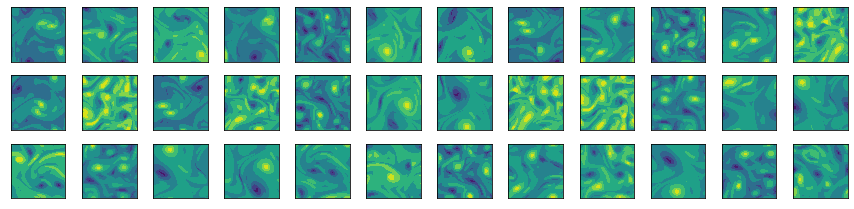

In [7]:
# Visualize select snapshots
axis_array = 2 * [np.linspace(0, 2 * np.pi, 128)]
fig_shape = (3, 12)
fig = plt.figure(figsize=fig_shape[::-1])
for i in range(prod(fig_shape)):
    ax = fig.add_subplot(*fig_shape, i+1)
    ax.contourf(*axis_array, snapshots[i][0])
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

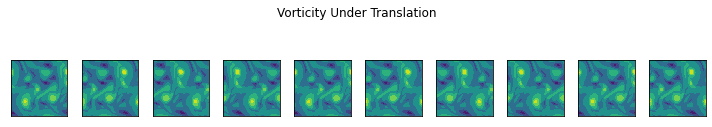

In [8]:
# Visualize shift
fig_shape = (1, 10)
fig = plt.figure(figsize=(10, 2))
for i in range(prod(fig_shape)):
    ax = fig.add_subplot(*fig_shape, i+1)
    snap = DS.translate_fx(snapshots[9][0], base_shape=base_shape, dx=dx, x_shift=(np.pi/2)*i)
    # snap = DS.all_syms(snapshots[9][0], base_shape=base_shape, dx=dx, m=326*i)
    ax.contourf(*axis_array, snap)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_title('; '.join([f'{x:.02f}' for x in translate_vector]))
fig.suptitle('Vorticity Under Translation')
fig.tight_layout()
plt.show()

# Train

In [9]:
epochs = 801
batch_size = 64
embedded_dim = 96
lr = .0003

epoch_pd = 100
dataset_size = len(snapshots)

In [10]:
autoencoder = AEModel(embedded_dim=embedded_dim).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)

In [11]:
%%time
try:
    # Load model
    autoencoder.load_state_dict(torch.load(f'./models/model_{embedded_dim}_{dataset_size}_{epochs-1}-{batch_size}-{lr}.h5'))
    autoencoder.eval();
except:
    # Train model
    autoencoder.train()
    batches = ceil(len(snapshots) / batch_size)
    for epoch in range(epochs):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        for _ in range(batches):
            batch = snapshots[np.random.choice(range(len(snapshots)), batch_size)].to(device)
            _, logits = autoencoder(batch)
            loss = (logits - batch).square().sum() / prod(batch.shape)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % epoch_pd == 0:
            # CLI
            print(f'Epoch: {epoch} \tLoss:{float(loss.detach())}')
            # Save model
            torch.save(autoencoder.state_dict(), f'./models/model_{embedded_dim}_{len(snapshots)}_{epoch}-{batch_size}-{lr}.h5')
            autoencoder.eval();

Epoch: 0 	Loss:0.018253143876791
Epoch: 100 	Loss:0.004982569254934788
Epoch: 200 	Loss:0.004165184684097767
Epoch: 300 	Loss:0.003999865148216486
Epoch: 400 	Loss:0.0032270806841552258
Epoch: 500 	Loss:0.0031930487602949142
Epoch: 600 	Loss:0.0030887159518897533
Epoch: 700 	Loss:0.0031419266015291214
Epoch: 800 	Loss:0.0032155923545360565
CPU times: user 3h 47min 5s, sys: 2min 30s, total: 3h 49min 36s
Wall time: 3h 48min 54s


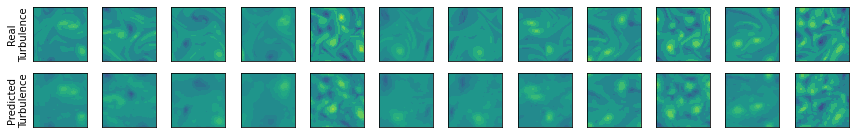

In [12]:
# Preview reconstruction
fig_shape = (2, 12)
fig = plt.figure(figsize=fig_shape[::-1])
for i in range(fig_shape[1]):
    # Actual
    ax = fig.add_subplot(*fig_shape, i+1)
    ax.contourf(*axis_array, snapshots[i, 0, :, :], vmin=-1, vmax=1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Real\nTurbulence')
    
    # Predicted
    ax = fig.add_subplot(*fig_shape, fig_shape[1]+i+1)
    ax.contourf(*axis_array, autoencoder(snapshots[[i]].to(device))[1].detach().cpu()[0, 0, :, :], vmin=-1, vmax=1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Predicted\nTurbulence')
fig.tight_layout()
plt.show()

In [ ]:
# Calculate dissipation
autoencoder.to(device)
actual_diss = [DS.compute_diss(snap[0], 40) for snap in test_snapshots]
predicted_diss = [DS.compute_diss(autoencoder(snap.unsqueeze(0).to(device))[1][0][0].detach().cpu(), 40) for snap in test_snapshots]

# Plot dissipation
fig_shape = (1, 1)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(*fig_shape, 1)
sns.distplot(predicted_diss, 20, ax=ax, label='Predicted')
sns.distplot(actual_diss, 20, ax=ax, label='Actual')
plt.xlabel('Dissipation')
plt.xticks([])
plt.yticks([])
plt.legend();

# Eigenanalysis

In [13]:
%%time
# Arrange data
n = 9
alpha = 2*np.pi/n
omega = snapshots
omega_test = test_snapshots
omega_prime = torch.stack([torch.Tensor(DS.translate_fx(z, base_shape=base_shape, dx=dx, x_shift=alpha)) for z in omega]).unsqueeze(1)
E = torch.cat([autoencoder(snap.unsqueeze(0).to(device))[0].T.detach() for snap in omega], dim=1).cpu()
E_test = torch.cat([autoencoder(snap.unsqueeze(0).to(device))[0].T.detach() for snap in omega_test], dim=1).cpu()
E_prime = torch.cat([autoencoder(snap.unsqueeze(0).to(device))[0].T.detach() for snap in omega_prime], dim=1).cpu()

CPU times: user 20.3 s, sys: 35.8 ms, total: 20.3 s
Wall time: 20.3 s


## Analytic Solution

In [14]:
# Solve for T
E_plus = torch.linalg.pinv(E).detach()
T = E_prime @ E_plus

# Assess fit quality
fit_quality = (torch.matmul(T, E) - E_prime).absolute().mean()
print(f'Shift operator average error: {fit_quality:.4f}')
eigenvalue_fit_quality = (torch.matmul(torch.linalg.matrix_power(T, n), E) - E).absolute().mean()
print(f'Eigenvalue constraint average error: {eigenvalue_fit_quality:.4f}')
inverse_quality = ((E_plus @ E) - torch.eye(E_plus.shape[0])).absolute().mean()
print(f'Inverse average error: {inverse_quality:.4f}')
print(f'E average value: {E.absolute().mean():.4f}')

Shift operator average error: 0.1030
Eigenvalue constraint average error: 0.1428
Inverse average error: 0.0040
E average value: 0.5780


## Gradient-Descent

In [15]:
# %%time
# # Train model
# epochs = 10001
# epoch_pd = 2000
# batch_size = 32
# stop_err = 1e-5
# batches = ceil(len(snapshots) / batch_size)
# stop_now = False

# # Generate shifts
# try:
#     assert E_steps[-1].shape == E.shape
#     assert len(E_steps) == n
# except:
#     print('Generating shifts...')
#     E_steps = []
#     for i in range(1, n+1):
#         omega_shift = torch.stack([torch.Tensor(DS.translate_fx(z, base_shape=base_shape, dx=dx, x_shift=alpha*i)) for z in omega]).unsqueeze(1)
#         E_steps.append(autoencoder(omega_shift)[0].T.detach())

# # GPU
# # Using T
# # T = T.to(device).detach().requires_grad_(True)  # T = torch.rand(2*[E.shape[0]], requires_grad=True).to(device).detach().requires_grad_(True)
# # optimizer = torch.optim.AdamW([T], lr=.001)
# # Using E_plus
# E_plus = E_plus.to(device).detach().requires_grad_(True)  # E_plus = torch.rand(E.shape[::-1], requires_grad=True).to(device).detach().requires_grad_(True)
# optimizer = torch.optim.AdamW([E_plus], lr=.001)

# E_steps = [x.to(device) for x in E_steps]

# for epoch in range(epochs):
#     for _ in range(batches):
#         batch = snapshots[np.random.choice(range(len(test_snapshots)), batch_size)].to(device)
        
#         # Transform in series
#         loss = []
#         T = E_steps[0] @ E_plus  # Using E_plus
#         # for i, E_step in enumerate(E_steps):  # All constraints
#         for i, E_step in zip((0, n-1), (E_steps[0], E_steps[-1])):  # Only main constraints
#             loss.append((torch.matmul(torch.linalg.matrix_power(T, i+1), E_steps[-1]) - E_step).square().sum() / prod(E_step.shape))
#         # Using E_plus
#         # loss.append(((E_plus @ E_steps[-1]) - torch.eye(E_plus.shape[0]).to(device)).square().sum())  # / prod(E_steps[-1].shape))

#         # Early stop
#         if sum(loss) < stop_err:
#             stop_now = True
#             break

#         # Step
#         optimizer.zero_grad()
#         sum(loss).backward()
#         optimizer.step()
        
#     # CLI
#     if epoch % epoch_pd == 0:
#         # fancy_output = f'Epoch: {epoch} \tCombined Loss: {sum(loss):.4f} \tSO: {loss[0]:.4f} \tEC: {loss[n-1]:.4f}'
#         fancy_output = f'Epoch: {epoch} \tCombined Loss: {sum(loss):.4f} \tSO: {loss[0]:.4f} \tEC: {loss[1]:.4f}'
#         fancy_output += f'\tI: {loss[-1]:.4f}'
#         print(fancy_output)
#     # Early stop
#     if stop_now:
#         break
# # Using E_plus
# E_plus = E_plus.detach().cpu()
# T = E_prime @ E_plus
# # Using T
# # T = T.detach().cpu()

# # Assess fit quality
# fit_quality = (torch.matmul(T, E) - E_prime).absolute().mean()
# print(f'Shift operator average error: {fit_quality:.4f}')
# eigenvalue_fit_quality = (torch.matmul(torch.linalg.matrix_power(T, n), E) - E).absolute().mean()
# print(f'Eigenvalue constraint average error: {eigenvalue_fit_quality:.4f}')
# # Using E_plus
# inverse_quality = ((E_plus @ E) - torch.eye(E_plus.shape[0])).absolute().mean()
# print(f'Inverse average error: {inverse_quality:.4f}')
# print(f'E average value: {E.absolute().mean():.4f}')

## Eigenanalysis

In [16]:
# Get eigenvalues
Lambda, V = [t.detach() for t in torch.linalg.eig(T)]
W = torch.linalg.eig(T.T)[1].detach()
wavenumbers = (torch.log(Lambda) / (1j*alpha))

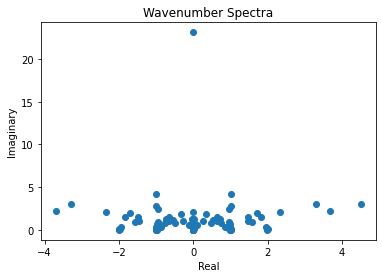

In [17]:
# Plot eigenvalue spectra
plt.scatter(wavenumbers.real, wavenumbers.imag)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Wavenumber Spectra');

In [99]:
# tol = .1  # 1e-12
wavenumbers_unique, idx, counts = np.unique(wavenumbers.real, return_counts=True, return_index=True)
P = []
used_l = []
state = None
# for l in range(int(1+wavenumbers.real.nan_to_num().max())):
for l in wavenumbers_unique[np.argwhere(counts > 1)]:
    if np.isnan(l):
        continue
    # idx = np.argwhere(np.abs(wavenumbers.real - l) < tol).squeeze()
    # Only consider degenerate eigenvalues
    # if len(idx.shape) < 1 or idx.shape[0] < 2:
    #     continue
    idx = np.argwhere(wavenumbers.real == l[0])[0]
    used_l.append(l)
    
    # Calculate eigspace
    # eigvecs = V[:, idx].detach()
    # dot = E_test.T.detach().type(torch.complex64) @ eigvecs
    # projector = dot @ eigvecs.T
    # projector = projector.unsqueeze(1)
    
    # Real PCA with package
    # V_mean = V[:, idx].mean(dim=1)
    # from sklearn.decomposition import PCA
    # pca = PCA(1).fit(V[:, idx].T.real).components_
    # eigvecs = torch.Tensor(pca).T
    # projector = (E_test.T @ eigvecs) @ eigvecs.T
    # projector = projector.unsqueeze(1)
    
    # PCA of eigspace
    V_mean = V[:, idx].mean(dim=1)
    Z = V[:, idx].T - V_mean
    lam, v = torch.linalg.eig(Z.real.T @ Z.real)
    sort_idx = list(np.argsort(lam))[::-1]
    eigvecs = v[:, sort_idx].detach()
    dot = (E_test.T.type(torch.complex64) @ eigvecs)
    projector = dot[:, :1] @ eigvecs[:, :1].T  # Use primary PCA mode
    projector = projector.unsqueeze(1)
    
    # PCA of projector
    # eigvecs = V[:, idx].detach()
    # p = (
    #     (E_test.T.detach().type(torch.complex64) @ eigvecs).T.unsqueeze(0).expand(eigvecs.shape[0], -1, -1)
    #     * eigvecs.unsqueeze(2).expand(-1, -1, E_test.shape[1])
    # ).transpose(0, 2)
    # p_mean = p.mean(dim=1).unsqueeze(1).expand(-1, len(idx), -1)
    # Z = p - p_mean
    # lam, v = torch.linalg.eig(torch.bmm(Z.transpose(1,2), Z))
    # sort_idx = lam.real.argsort(dim=1).flip(1)
    # eigvecs = torch.stack([vecs[:, idx[[0]]] for vecs, idx in zip(v, sort_idx)], 0).detach()
    # projector = torch.bmm(p, eigvecs) @ eigvecs.transpose(1, 2) + p_mean
    
    # Calculate eigspace via bi-orthogonal basis
    # V_l, W_l = V[:, idx], W[:, idx]
    # Q, R = torch.linalg.qr(W_l.conj().T @ V_l)
    # Xi_l = V_l @ torch.inverse(R)
    # Xi_dagger_l = (torch.inverse(Q) @ W_l.conj().T).conj().T
    # projector = (E_test.T.detach().type(torch.complex64) @ Xi_dagger_l).unsqueeze(2).expand(-1, -1, E.shape[0]) * Xi_l.T
    
    # Record projections
    P.append(projector)
    # Record state space
    if state is None:
        state = dot
    else:
        state.cat(dot[:, :5].abs(), 1)
    
print(f'Applicable wavenumbers: {[float(x) for x in used_l]}')
print(f'Fraction eigvecs used: {float(sum(counts[np.argwhere(wavenumbers_unique == l)] for l in used_l) / len(wavenumbers)):.2f}')
SP = [p.sum(dim=1) for p in P]

Applicable wavenumbers: [0.0]
Fraction eigvecs used: 0.07


## Eigenmodes

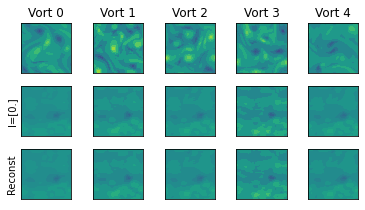

In [101]:
# Preview reconstruction
autoencoder.cpu()
sample_num = 5
fig_shape = (len(SP)+2, omega_test.shape[0])
fig = plt.figure(figsize=fig_shape[::-1])
for i in range(fig_shape[0]):
    # Actual
    if i == 0:
        for j, vort in enumerate(omega_test[:sample_num]):
            ax = fig.add_subplot(*fig_shape, j+1)
            ax.contourf(*axis_array, vort[0, :, :], vmin=-1, vmax=1)
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'Vort {j}')
    
    # Predicted
    elif i != fig_shape[0]-1:
        if i == 1:
            decodes = autoencoder.decoder(SP[0][:sample_num].real).detach().cpu()
        else:
            decodes = autoencoder.decoder((SP[0][:sample_num]+SP[i-1][:sample_num]).real).detach().cpu()
        for j, vort in enumerate(decodes):
            ax = fig.add_subplot(*fig_shape, i*fig_shape[1]+1+j)
            ax.contourf(*axis_array, vort[0, :, :], vmin=-1, vmax=1)
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0:
                ax.set_ylabel(f'l={used_l[i-1]}')
    # Reconstructed
    else:
        decodes = autoencoder.decoder(sum(SP)[:sample_num].real).detach().cpu()
        for j, vort in enumerate(decodes):
            ax = fig.add_subplot(*fig_shape, i*fig_shape[1]+1+j)
            ax.contourf(*axis_array, vort[0, :, :], vmin=-1, vmax=1)
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0:
                ax.set_ylabel(f'Reconst')
fig.tight_layout()
plt.show()

## State Space Visualization

/home/thema/repos/autoeig/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/thema/repos/autoeig/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


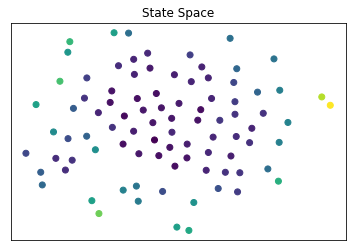

In [96]:
from sklearn.manifold import TSNE
autoencoder.to(device)
ssvis = TSNE(n_components=2, init='pca').fit_transform(state.real)
diss = [DS.compute_diss(vort[0], 40) for vort in autoencoder.decoder(E_test.T.to(device)).detach().cpu()]
plt.scatter(*ssvis.T, c=diss)
plt.title('State Space')
plt.xticks([])
plt.yticks([]);